# Working with surface data

Surface objects often come with custom data types and objects. In this tutorial will will predominantly use [vedo](https://vedo.embl.es/), which offers the [Mesh](https://vedo.embl.es/autodocs/content/vedo/mesh.html) class for this.

Before running this notebook, please additionally install the following packages:
- `pygeodesic` package with `pip install pygeodesic`
- `napari-process-points-and-surfaces` with `pip install napari_process_points_and_surfaces`

In [1]:
import vedo
import napari
import numpy as np
from pygeodesic import geodesic
import napari_process_points_and_surfaces as nppas

Validation errors in config file(s).
The following fields have been reset to the default value:

schema_version
  value is not a valid tuple (type=type_error.tuple)



In [2]:
mesh = vedo.Mesh(vedo.dataurl + "bunny.obj")

In [2]:
mesh

(Mesh)0000021278707220

In this case, the point coordinates are all <1 - we scale the points up a bit so that things are a bit easier to handle down the road

In [3]:
mesh = vedo.mesh.Mesh((mesh.points() * 10, mesh.faces()))

In order to display this data in napari, we need to change the format so that napari  understands it. According to the napari surface layer documentation, a surface layer consists of a tuple of three elements `(points, faces, values)`, whereas the `values` entry is optional. We can retrieve these from the vedo object as follows:

In [4]:
points = mesh.points()
faces = np.asarray(mesh.faces())
points

array([[-0.0341018 ,  1.30319571,  0.21754369],
       [-0.8171916 ,  1.52501452,  0.29656088],
       [-0.30543479,  1.24778855,  0.0109834 ],
       ...,
       [-0.13895491,  1.6787169 , -0.2189723 ],
       [-0.69413   ,  1.51218474, -0.4453854 ],
       [-0.55039799,  0.57309699,  0.169909  ]])

### Exercise

Have a look at the faces object.  What do the values refer to?

In [6]:
viewer = napari.Viewer(ndisplay=3)

In [7]:
bunny = (mesh.points(), np.asarray(mesh.faces()).astype(int))

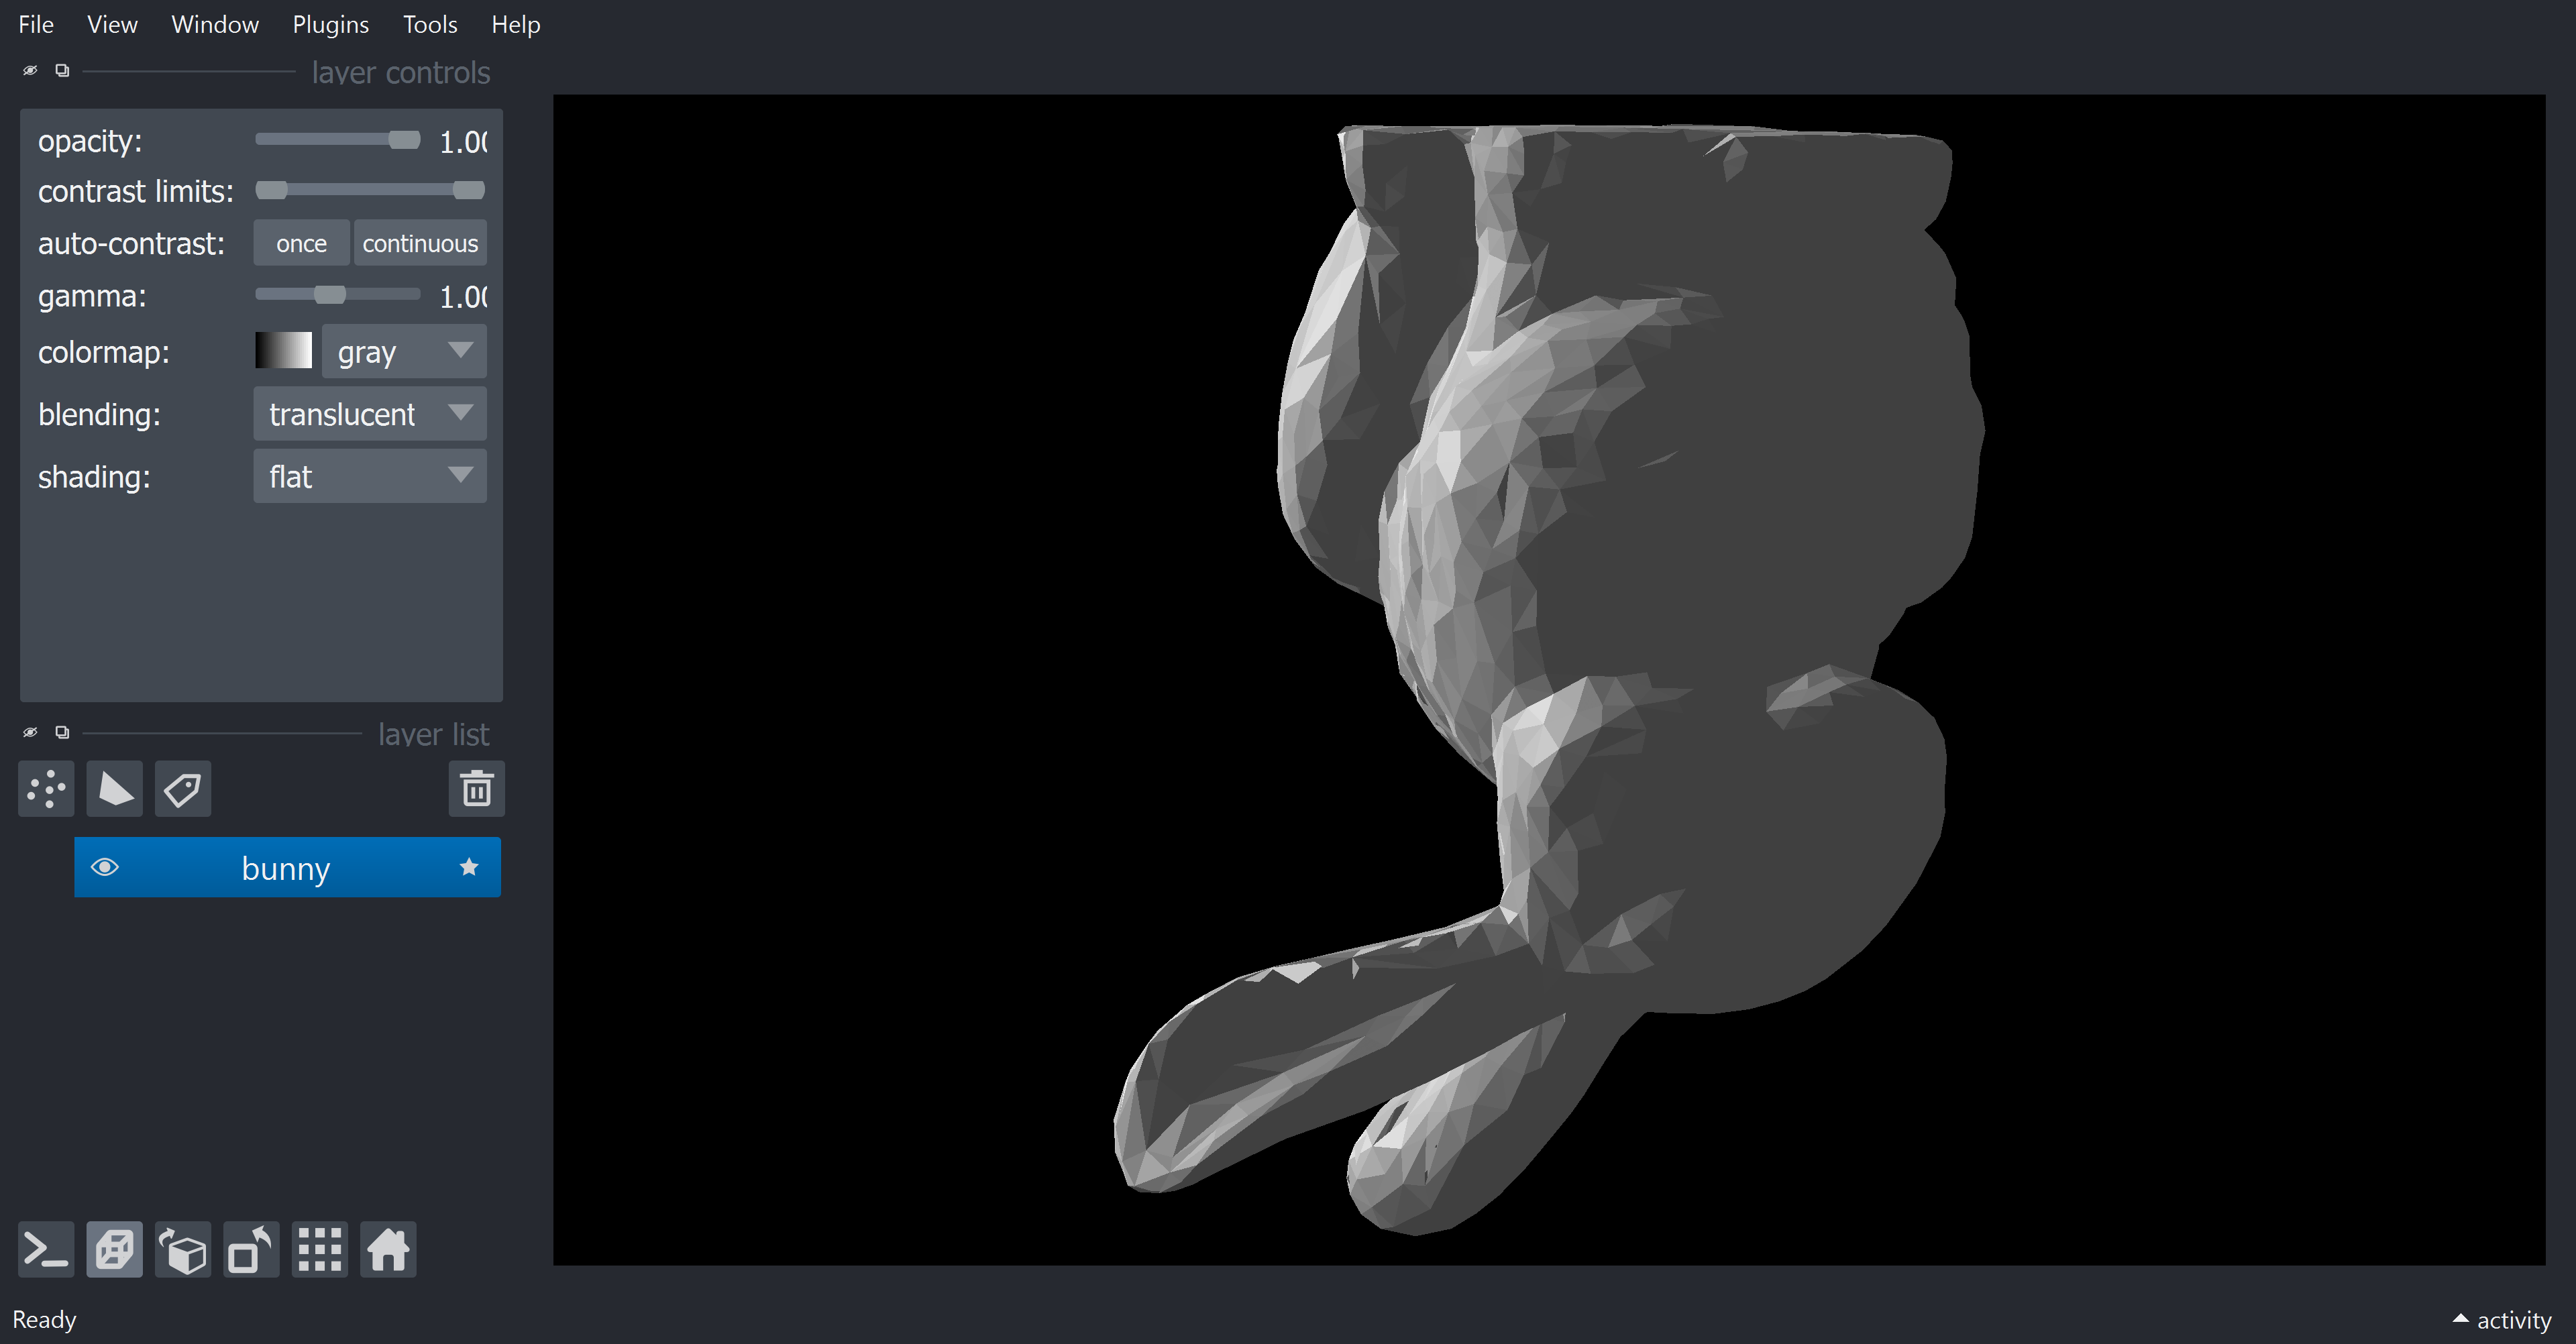

In [8]:
viewer.add_surface(bunny)
napari.utils.nbscreenshot(viewer)

## Assigning values to meshes

To demonstrate how assigning values to meshes works, we could simply add each points' x_coordinate as a value to the mesh:

In [9]:
bunny_with_values = (points, faces, points[:, 1])
viewer.add_surface(bunny_with_values, colormap='magma')

<Surface layer 'bunny_with_values' at 0x21221ed6a90>

## Measuring features

We can use vedo to measure features of the object in a simple fashion:

In [10]:
print('Surface area:', mesh.area())
print('Volume:', mesh.volume())

Surface area: 5.646863245482599
Volume: 0.7620278501410354


In [11]:
print('Number of points:', mesh.N())

Number of points: 2503


In [12]:
ellipsoid = vedo.pcaEllipsoid(mesh)

In [13]:
print('Asphericity:', ellipsoid.asphericity())

Asphericity: 0.17055947344260192


In [14]:
print('Ellipsoid major axis 1:', ellipsoid.axis1)
print('Ellipsoid major axis 2:', ellipsoid.axis2)
print('Ellipsoid major axis 3:', ellipsoid.axis3)

Ellipsoid major axis 1: [-0.65257005  0.74304836 -0.14842997]
Ellipsoid major axis 2: [-0.73223167 -0.56800683  0.37577257]
Ellipsoid major axis 3: [0.19490796 0.35390306 0.91474779]


In [19]:
curvature, fit_residue =  nppas.add_spherefitted_curvature(bunny)

In [20]:
viewer.add_surface(curvature[0], **curvature[1])

<Surface layer 'curvature' at 0x21228801a00>

## Geodesic distances

[Geodesic](https://en.wikipedia.org/wiki/Geodesic) distances in the context of mesh objects are the shortest distance between two points `A` and `B` on the surface. This is equivalent to typical way-finding problems that occur in many contexts, such as automobile navigation: Similar to the edges and vertices on a surface, streets and crossings represent a graph through which the fastest route needs to be found. A typical algorithm used for such problems is the [Djikstra algorithm](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm).

In [21]:
geoalg = geodesic.PyGeodesicAlgorithmExact(mesh.points(), mesh.faces())

We can calculate distances between any two points (as gien by their indeces):

In [22]:
distance, path = geoalg.geodesicDistance(639, 834)

In [23]:
print('Measured distance:', distance)

Measured distance: 2.258314916388162


The `path` variable contains points along the way:

In [24]:
viewer.add_points(path, size=0.01, face_color='red')

<Points layer 'path' at 0x2121d513d60>

For better visualization, we can also convert this to a vectors object by subtracting the points from each other - this gives us thhe vectors (A,B), (B,C), (C,D), etc.

In [25]:
vectors = []
for i in range(len(path)-1):
    vectors.append(path[i+1] - path[i])

vectors = np.asarray(vectors)

In [26]:
napari_vectors_geodesics = np.stack([path[:-1], vectors]).transpose((1,0,2))
viewer.add_vectors(napari_vectors_geodesics, edge_width=0.01, edge_color='blue')

<Vectors layer 'napari_vectors_geodesics' at 0x2121cb9df70>

## Exercise 1:

Use the pygeodesics package and plot the distance of each point on the surface to a point on the surface of your choice.

*Hint*: You can take two (legit) approaches to this problem:
- Write a `for`-loop over each point on the surface and calculate its distance to a point of your choice
- Use the `geoalg.geodesicDistances()`  function for this

## Exercise 2:

Use `napari_process_points_and_surfaces` to measure some more features on the bunny object and visualize them in napari. You can either do this from code (`napari_process_points_and_surfaces.add_quality()`) or interactively from the napari viewer (`Tools > Measurement > Surface quality (vedo)`)